## Minimum Variance Portfolio Backtest.

In [1]:
from __future__ import annotations


from imitation.algorithms.adversarial.airl import AIRL
from stable_baselines3 import SAC

from qamsi.cov_estimators.rl.inverse_rl.irl_estimator import IRLCovEstimator

from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from run import Dataset, initialize

In [2]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30
ESTIMATION_WINDOW = 365

trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=1,
)

ESTIMATOR = IRLCovEstimator(
    shrinkage_type="linear",
    imitation_trainer_cls=AIRL,
    policy_builder=lambda env: SAC("MlpPolicy", env, verbose=0, device="mps"),
    dataset=DATASET,
    trading_config=trading_config,
    rebal_freq=REBAL_FREQ,
    topn=TOP_N,
    window_size=None,
    refit_policy=True,
    random_seed=12,
)

In [3]:
preprocessor, runner = initialize(
    dataset=DATASET,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [4]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.955    |
|    disc/disc_acc_expert             | 0.912    |
|    disc/disc_acc_gen                | 0.998    |
|    disc/disc_entropy                | 0.108    |
|    disc/disc_loss                   | 0.134    |
|    disc/disc_proportion_expert_pred | 0.457    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 3.4e+03  |
|    disc/n_expert                    | 50       |
|    disc/n_generated                 | 50       |
|    gen/rollout/ep_rew_wrapped_mean  | -1.3     |
|    gen/time/episodes                | 3.4e+03  |
|    gen/time/fps                     | 26       |
|    gen/time/time_elapsed            | 0        |
|    gen/time/total_timesteps         | 3.4e+03  |
|    gen/train/actor_loss             | 0.279    |
|    gen/train/critic_loss            | 3.4      |
|    gen/train/ent_coef        


Computing Weights:  10%|▉         | 28/283 [10:14:27<93:15:59, 1316.71s/it]


KeyboardInterrupt: 

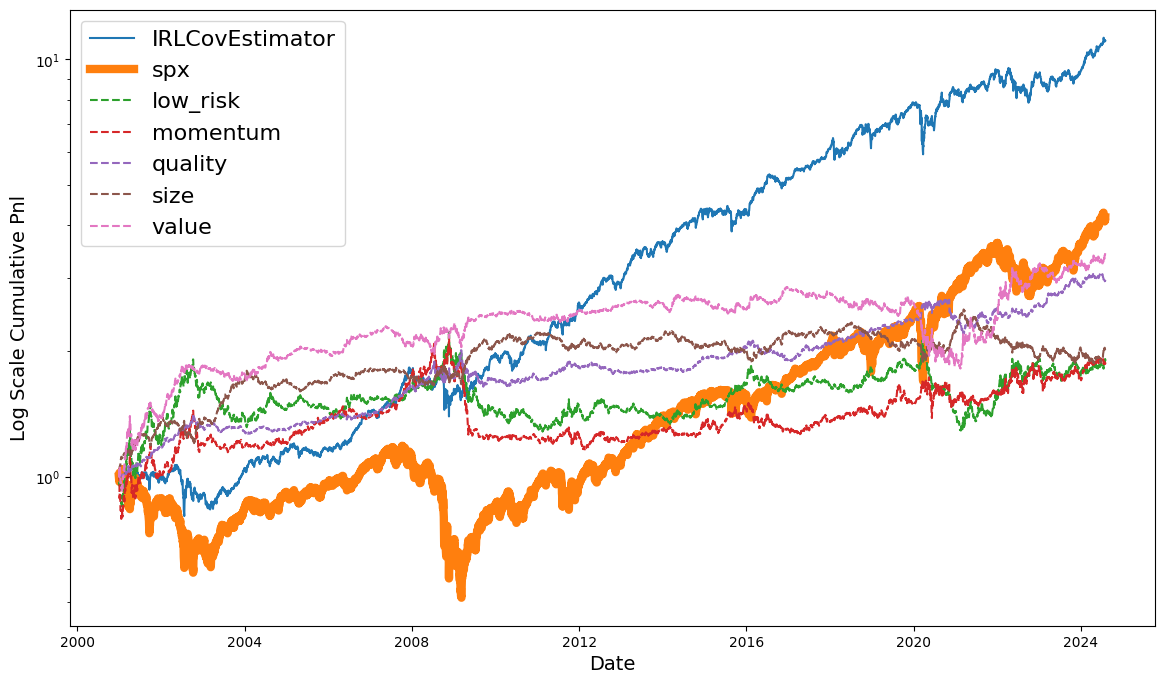

In [5]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

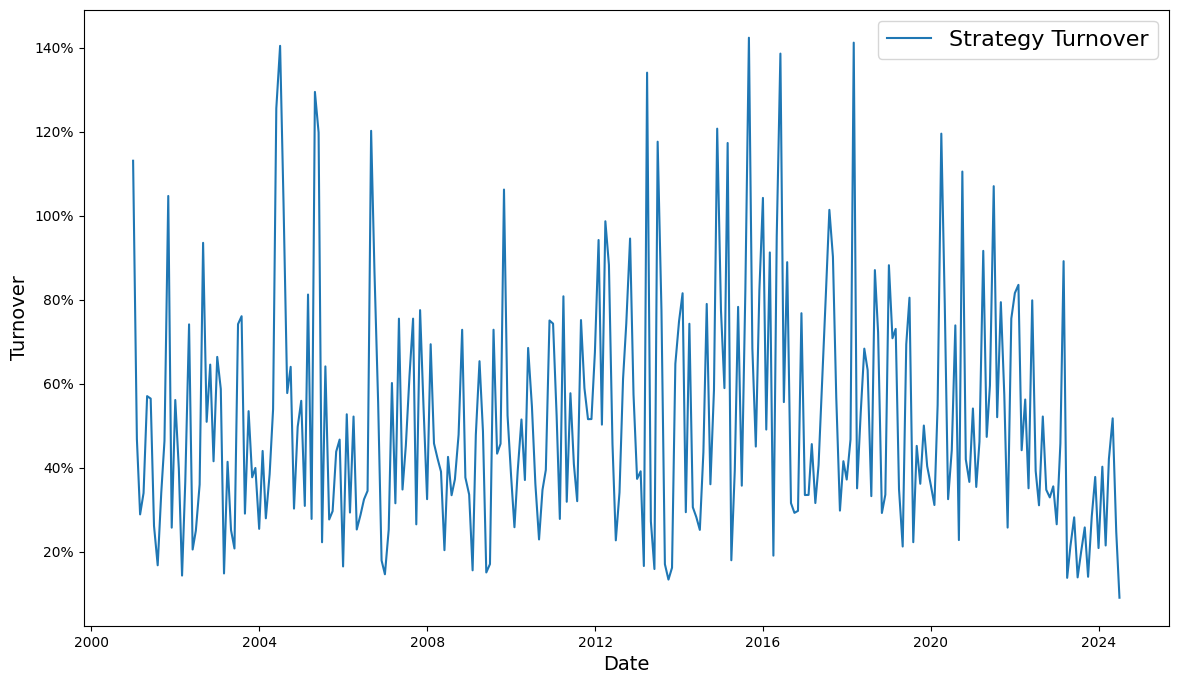

In [6]:
runner.plot_turnover()

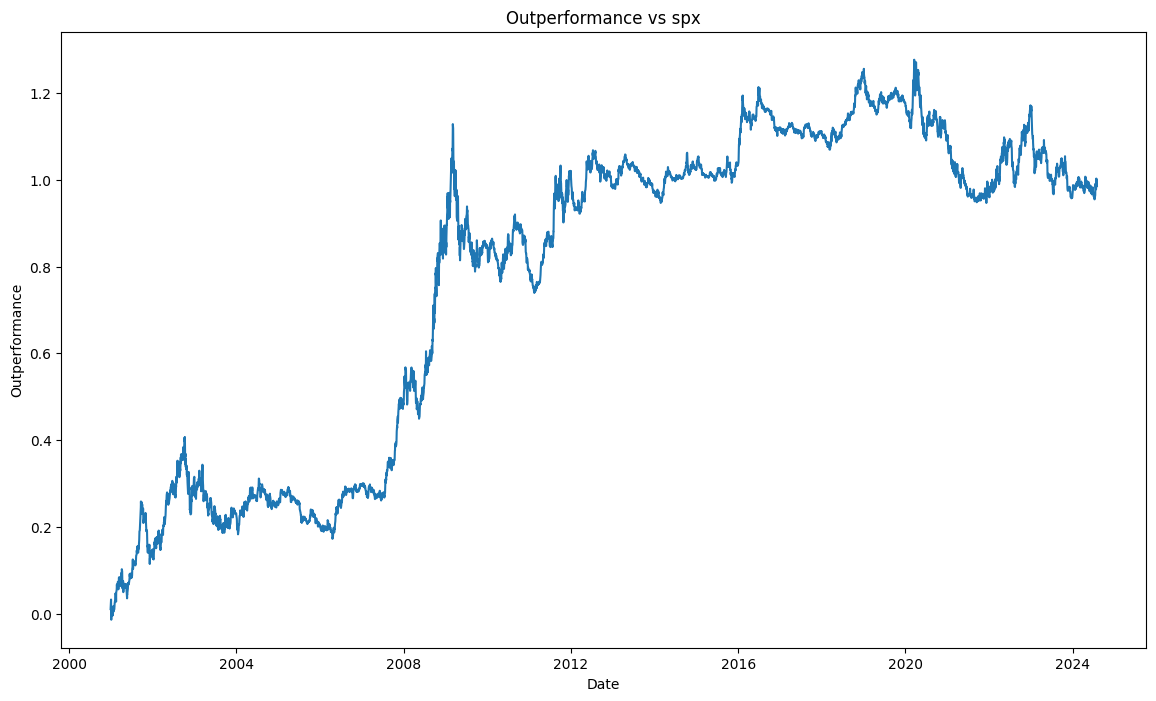

In [7]:
runner.plot_outperformance(mkt_only=True)

In [8]:
runner.save(f"{DATASET.name}_{TOP_N}_" + strategy_name + f"_rebal{REBAL_FREQ}")